In [15]:
import os
from pathlib import Path
from natsort import natsorted
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from typing import List, Tuple, Dict
from dataclasses import dataclass
import json

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.11.0.dev20260116+cu128
CUDA available: True


In [16]:
@dataclass
class TilePair:
    """Immutable record of a single image-mask pair with WSI identity"""
    image_path: Path
    mask_path: Path
    wsi_id: str
    tile_id: str
    
    def __post_init__(self):
        """Validate that paths exist"""
        if not self.image_path.exists():
            raise FileNotFoundError(f"Image not found: {self.image_path}")
        if not self.mask_path.exists():
            raise FileNotFoundError(f"Mask not found: {self.mask_path}")


class WSIDatasetIndex:
    """
    Builds and validates an immutable index of WSI tile pairs.
    This is the single source of truth for what data exists.
    """
    
    def __init__(self, export_root: Path, strict_mode: bool = True, 
                 allow_size_mismatch: bool = False):  # <-- NEW PARAMETER
        self.export_root = Path(export_root)
        self.strict_mode = strict_mode
        self.allow_size_mismatch = allow_size_mismatch  # <-- NEW
        self.tile_pairs: List[TilePair] = []
        self.wsi_groups: Dict[str, List[TilePair]] = {}
        self.validation_report: Dict = {
            'total_wsis_found': 0,
            'valid_wsis': 0,
            'skipped_wsis': [],
            'total_pairs': 0,
            'issues': []
        }
        
    def build_index(self) -> 'WSIDatasetIndex':
        """Build the dataset index with full validation"""
        print("="*60)
        print("Building WSI Dataset Index...")
        print("="*60)
        
        if not self.export_root.exists():
            raise FileNotFoundError(f"Export root not found: {self.export_root}")
        
        wsi_folders = [d for d in self.export_root.iterdir() if d.is_dir()]
        self.validation_report['total_wsis_found'] = len(wsi_folders)
        
        for wsi_folder in wsi_folders:
            try:
                pairs = self._process_wsi_folder(wsi_folder)
                if pairs:
                    self.tile_pairs.extend(pairs)
                    self.wsi_groups[wsi_folder.name] = pairs
                    self.validation_report['valid_wsis'] += 1
            except Exception as e:
                if self.strict_mode:
                    raise
                else:
                    self.validation_report['skipped_wsis'].append({
                        'wsi_id': wsi_folder.name,
                        'reason': str(e)
                    })
                    print(f"⚠️  Skipping {wsi_folder.name}: {e}")
        
        self.validation_report['total_pairs'] = len(self.tile_pairs)
        self._print_summary()
        
        if self.strict_mode and len(self.validation_report['issues']) > 0:
            raise ValueError(f"Validation failed with {len(self.validation_report['issues'])} issues")
        
        return self
    
    def _process_wsi_folder(self, wsi_folder: Path) -> List[TilePair]:
        """Process a single WSI folder and return validated tile pairs"""
        wsi_id = wsi_folder.name
        img_dir = wsi_folder / "images"
        msk_dir = wsi_folder / "masks"
        
        # Check directory structure
        if not img_dir.exists():
            raise FileNotFoundError(f"Missing images directory in {wsi_id}")
        if not msk_dir.exists():
            raise FileNotFoundError(f"Missing masks directory in {wsi_id}")
        
        # Get all image files
        image_files = list(img_dir.glob("*.[pP][nN][gG]"))
        
        if len(image_files) == 0:
            raise ValueError(f"No PNG files found in {wsi_id}/images")
        
        # Check for duplicates
        if len(image_files) != len(set(image_files)):
            duplicates = [f for f in image_files if image_files.count(f) > 1]
            raise ValueError(f"Duplicate image files detected in {wsi_id}: {duplicates[:5]}")
        
        # Build pairs by explicit matching
        pairs = []
        unpaired_images = []
        
        for img_path in natsorted(image_files):
            mask_path = self._find_corresponding_mask(img_path, msk_dir)
            
            if mask_path is None:
                unpaired_images.append(img_path.name)
                continue
            
            # Validate this specific pair
            self._validate_tile_pair(img_path, mask_path, wsi_id)
            
            # Create immutable pair record
            tile_id = img_path.stem
            pair = TilePair(
                image_path=img_path,
                mask_path=mask_path,
                wsi_id=wsi_id,
                tile_id=tile_id
            )
            pairs.append(pair)
        
        # Report unpaired images
        if unpaired_images:
            issue = f"{wsi_id}: {len(unpaired_images)} images without masks"
            self.validation_report['issues'].append(issue)
            
            if self.strict_mode:
                raise ValueError(f"{issue}. First 5: {unpaired_images[:5]}")
            else:
                print(f"⚠️  {issue}")
        
        print(f"✓ {wsi_id}: {len(pairs)} valid pairs")
        return pairs
    
    def _find_corresponding_mask(self, image_path: Path, mask_dir: Path) -> Path:
        """Find mask using explicit naming contract: tile_001.png -> tile_001_mask.png"""
        expected_mask_name = f"{image_path.stem}_mask.png"
        mask_path = mask_dir / expected_mask_name
        
        if mask_path.exists():
            return mask_path
        
        # Try case-insensitive variants
        for suffix in ["_mask.png", "_mask.PNG", "_MASK.png", "_MASK.PNG"]:
            alt_mask_path = mask_dir / f"{image_path.stem}{suffix}"
            if alt_mask_path.exists():
                return alt_mask_path
        
        return None
    
    def _validate_tile_pair(self, image_path: Path, mask_path: Path, wsi_id: str):
        """Validate semantic properties of an image-mask pair"""
        try:
            img = Image.open(image_path)
            mask = Image.open(mask_path)
            
            # Check 1: Shape match (MODIFIED TO ALLOW MISMATCH)
            if img.size != mask.size:
                issue = (
                    f"Shape mismatch in {wsi_id}/{image_path.name}: "
                    f"image={img.size}, mask={mask.size}"
                )
                
                if self.allow_size_mismatch:
                    # Just warn, don't fail
                    self.validation_report['issues'].append(issue)
                    print(f"⚠️  {issue} (will be resized during training)")
                else:
                    # Fail if not allowing mismatches
                    raise ValueError(issue)
            
            # Check 2: Image is RGB
            if img.mode != 'RGB':
                raise ValueError(f"Image is not RGB in {wsi_id}/{image_path.name}: mode={img.mode}")
            
            # Check 3: Mask is grayscale
            if mask.mode not in ['L', '1']:
                raise ValueError(f"Mask is not grayscale in {wsi_id}/{mask_path.name}: mode={mask.mode}")
            
            # Check 4: Mask value range
            mask_array = np.array(mask)
            unique_values = np.unique(mask_array)
            
            if not (set(unique_values).issubset({0, 1}) or set(unique_values).issubset({0, 255})):
                issue = f"Unexpected mask values in {wsi_id}/{mask_path.name}: unique values = {unique_values}"
                self.validation_report['issues'].append(issue)
                
                if self.strict_mode:
                    raise ValueError(issue)
                else:
                    print(f"⚠️  {issue}")
            
        except Exception as e:
            if self.strict_mode and not self.allow_size_mismatch:
                raise
    
    def _print_summary(self):
        """Print validation summary"""
        print("\n" + "="*60)
        print("Dataset Index Summary")
        print("="*60)
        print(f"WSIs found:        {self.validation_report['total_wsis_found']}")
        print(f"WSIs valid:        {self.validation_report['valid_wsis']}")
        print(f"WSIs skipped:      {len(self.validation_report['skipped_wsis'])}")
        print(f"Total tile pairs:  {self.validation_report['total_pairs']}")
        print(f"Validation issues: {len(self.validation_report['issues'])}")
        
        if self.wsi_groups:
            print(f"\nPairs per WSI:")
            for wsi_id, pairs in sorted(self.wsi_groups.items()):
                print(f"  {wsi_id}: {len(pairs)} pairs")
        
        print("="*60 + "\n")
    
    def get_train_val_split(self, val_ratio: float = 0.2, random_seed: int = 42) -> Tuple[List[TilePair], List[TilePair]]:
        """Split dataset by WSI (no leakage!)"""
        import random
        random.seed(random_seed)
        
        wsi_ids = list(self.wsi_groups.keys())
        random.shuffle(wsi_ids)
        
        n_val = max(1, int(len(wsi_ids) * val_ratio))
        val_wsi_ids = set(wsi_ids[:n_val])
        train_wsi_ids = set(wsi_ids[n_val:])
        
        train_pairs = [p for p in self.tile_pairs if p.wsi_id in train_wsi_ids]
        val_pairs = [p for p in self.tile_pairs if p.wsi_id in val_wsi_ids]
        
        print(f"\nTrain/Val Split (by WSI):")
        print(f"  Train WSIs: {len(train_wsi_ids)} ({len(train_pairs)} tiles)")
        print(f"  Val WSIs:   {len(val_wsi_ids)} ({len(val_pairs)} tiles)")
        print(f"  Train WSI IDs: {sorted(train_wsi_ids)}")
        print(f"  Val WSI IDs:   {sorted(val_wsi_ids)}")
        
        return train_pairs, val_pairs
    
    def save_index(self, output_path: Path):
        """Save index to JSON for reproducibility"""
        index_data = {
            'export_root': str(self.export_root),
            'strict_mode': self.strict_mode,
            'validation_report': self.validation_report,
            'tile_pairs': [
                {
                    'image_path': str(p.image_path),
                    'mask_path': str(p.mask_path),
                    'wsi_id': p.wsi_id,
                    'tile_id': p.tile_id
                }
                for p in self.tile_pairs
            ]
        }
        
        with open(output_path, 'w') as f:
            json.dump(index_data, f, indent=2)
        
        print(f"Index saved to {output_path}")

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """Residual block with two convolutions"""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        
        # Skip connection - adjust channels if needed
        self.skip = nn.Sequential()
        if in_ch != out_ch:
            self.skip = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1),
                nn.BatchNorm2d(out_ch)
            )
    
    def forward(self, x):
        residual = self.skip(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += residual  # Skip connection
        out = self.relu(out)
        
        return out

class AttentionGate(nn.Module):
    """Attention gate for skip connections"""
    def __init__(self, F_g, F_l, F_int):
        """
        F_g: channels in gating signal (from decoder)
        F_l: channels in skip connection (from encoder)
        F_int: intermediate channels
        """
        super().__init__()
        
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, 1, padding=0),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, 1, padding=0),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, 1, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        """
        g: gating signal from decoder
        x: skip connection from encoder
        """
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        
        # Add and apply activation
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        
        # Apply attention weights
        return x * psi

class ResidualAttentionUNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=4):  # out_ch=4 for your fungal categories
        super().__init__()
        
        # Encoder (downsampling) with residual blocks
        self.enc1 = ResidualBlock(in_ch, 64)
        self.enc2 = ResidualBlock(64, 128)
        self.enc3 = ResidualBlock(128, 256)
        self.enc4 = ResidualBlock(256, 512)
        
        # Bottleneck
        self.bottleneck = ResidualBlock(512, 1024)
        
        # Attention gates
        self.att4 = AttentionGate(F_g=512, F_l=512, F_int=256)
        self.att3 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.att2 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.att1 = AttentionGate(F_g=64, F_l=64, F_int=32)
        
        # Decoder (upsampling) with residual blocks
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = ResidualBlock(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = ResidualBlock(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = ResidualBlock(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = ResidualBlock(128, 64)
        
        # Output layer
        self.out = nn.Conv2d(64, out_ch, 1)
        
        # Pooling
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e4))
        
        # Decoder with attention gates and skip connections
        d4 = self.upconv4(b)
        e4_att = self.att4(g=d4, x=e4)  # Apply attention
        d4 = torch.cat([d4, e4_att], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.upconv3(d4)
        e3_att = self.att3(g=d3, x=e3)
        d3 = torch.cat([d3, e3_att], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        e2_att = self.att2(g=d2, x=e2)
        d2 = torch.cat([d2, e2_att], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        e1_att = self.att1(g=d1, x=e1)
        d1 = torch.cat([d1, e1_att], dim=1)
        d1 = self.dec1(d1)
        
        # Output
        out = self.out(d1)
        return out

# Usage example
if __name__ == "__main__":
    model = ResidualAttentionUNet(in_ch=3, out_ch=4)
    x = torch.randn(2, 3, 256, 256)  # Batch of 2, 256x256 RGB images
    output = model(x)
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")  # Should be [2, 4, 256, 256]
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

Input shape: torch.Size([2, 3, 256, 256])
Output shape: torch.Size([2, 4, 256, 256])
Total parameters: 32,796,912


In [18]:
# UPDATE THIS PATH TO DATA LOCATION
EXPORT_ROOT = Path(r"C:\Users\bachd\Desktop\QupathMLV2\exports_ml")

# Build validated index - ALLOW SIZE MISMATCHES
# The Dataset class will resize everything to the same size anyway
index = WSIDatasetIndex(EXPORT_ROOT, strict_mode=True, allow_size_mismatch=True)
index.build_index()

# Save index for reproducibility
index.save_index(Path("dataset_index.json"))

Building WSI Dataset Index...
✓ 410671L.svs[--series, 0]: 4 valid pairs

Dataset Index Summary
WSIs found:        1
WSIs valid:        1
WSIs skipped:      0
Total tile pairs:  4
Validation issues: 0

Pairs per WSI:
  410671L.svs[--series, 0]: 4 pairs

Index saved to dataset_index.json


In [19]:
class WSI_Dataset(Dataset):
    """
    PyTorch Dataset that operates on validated TilePair records.
    GUARANTEED to have correct image-mask pairing.
    """
    
    def __init__(self, tile_pairs: List[TilePair], img_size: int = 512):
        self.tile_pairs = tile_pairs
        
        # Ensure img_size is divisible by 16 for UNet
        if img_size % 16 != 0:
            img_size = ((img_size // 16) + 1) * 16
            print(f"Adjusting image size to {img_size} (must be divisible by 16)")
        
        self.img_size = img_size
        
        # Image transforms with ImageNet normalization
        self.img_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
        # Mask transforms (nearest neighbor to preserve labels)
        self.mask_transform = transforms.Compose([
            transforms.Resize((img_size, img_size), interpolation=Image.NEAREST),
            transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.tile_pairs)
    
    def __getitem__(self, idx):
        pair = self.tile_pairs[idx]
        
        # Load image and mask (Hard Pair)
        img = Image.open(pair.image_path).convert("RGB")
        mask = Image.open(pair.mask_path).convert("L")
        
        # Apply transforms
        img_tensor = self.img_transform(img)
        mask_tensor = self.mask_transform(mask)
        
        # Binarize mask (handles both 0/255 and 0/1 encodings)
        mask_tensor = (mask_tensor > 0.5).float()
        
        return img_tensor, mask_tensor

In [20]:
# Split by WSI (leak prevention)
train_pairs, val_pairs = index.get_train_val_split(
    val_ratio=0.2,    # 20% of WSIs for validation
    random_seed=42    # For reproducibility
)

# Verify no overlap
train_wsi_ids = set(p.wsi_id for p in train_pairs)
val_wsi_ids = set(p.wsi_id for p in val_pairs)

if train_wsi_ids & val_wsi_ids:
    print("❌ ERROR: WSI leakage detected!")
    print(f"   Overlapping WSIs: {train_wsi_ids & val_wsi_ids}")
else:
    print("✅ No WSI leakage - train and val are completely separate")


Train/Val Split (by WSI):
  Train WSIs: 0 (0 tiles)
  Val WSIs:   1 (4 tiles)
  Train WSI IDs: []
  Val WSI IDs:   ['410671L.svs[--series, 0]']
✅ No WSI leakage - train and val are completely separate


In [21]:
# TEMPORARY FIX: Use all data for training (only 2 samples available)
print("⚠️ WARNING: Using all data for training (no validation split)")
print(f"   Total tiles available: {len(index.tile_pairs)}")

# Define image size
IMG_SIZE = 512  

# Use ALL data for training
train_pairs = index.tile_pairs
train_dataset = WSI_Dataset(train_pairs, img_size=IMG_SIZE)

print(f"\nTrain dataset: {len(train_dataset)} tiles")

# Create only train loader
BATCH_SIZE = 2  # Set to match your data size (you have 2 tiles)
NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available()
)

# No validation loader for now
val_loader = None

# Quick check
train_imgs, train_masks = next(iter(train_loader))
print(f"\nBatch shapes:")
print(f"  Images: {train_imgs.shape}")
print(f"  Masks: {train_masks.shape}")

⚠️ WARNING: Using all data for training (no validation split)
   Total tiles available: 4

Train dataset: 4 tiles

Batch shapes:
  Images: torch.Size([2, 3, 512, 512])
  Masks: torch.Size([2, 1, 512, 512])


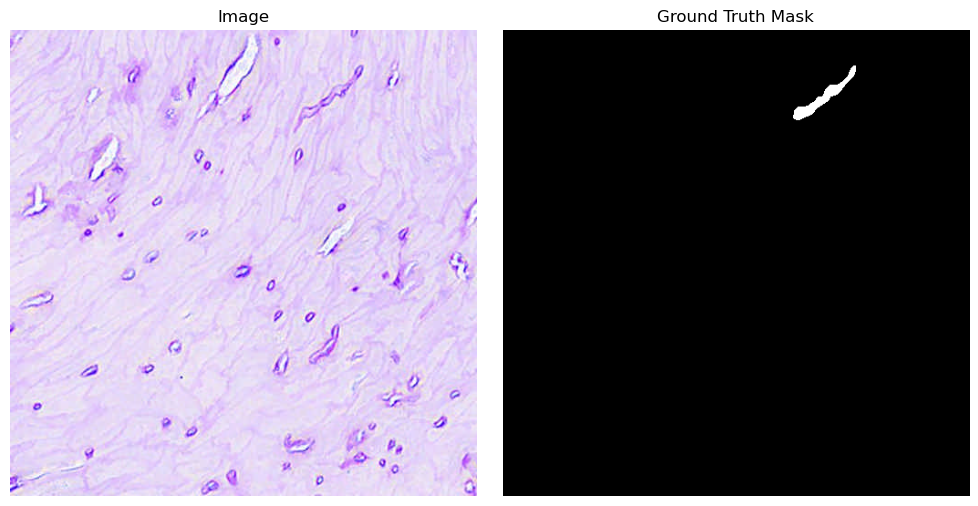

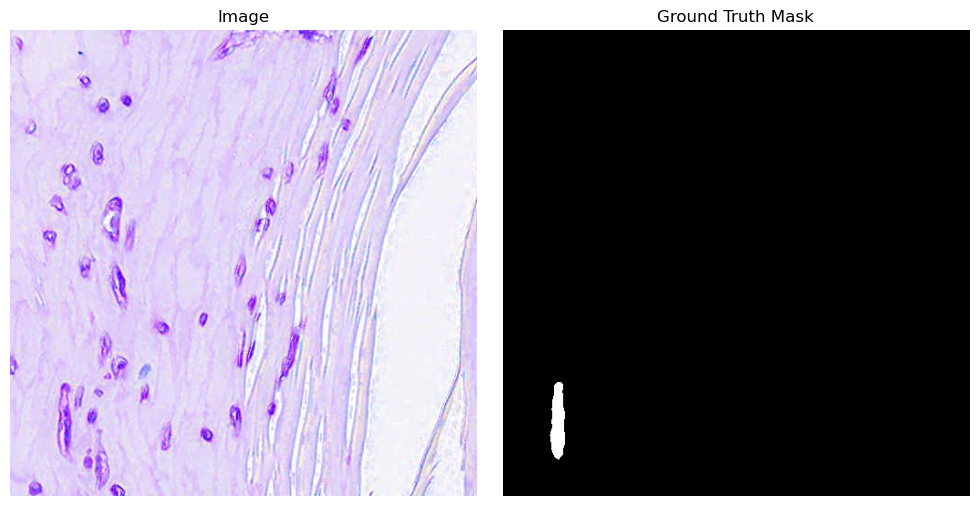

In [22]:
# Visualize first 2 samples from training set
for i in range(min(2, train_imgs.size(0))):
    # Denormalize image for visualization
    img_np = train_imgs[i].permute(1,2,0).numpy()
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    
    mask_np = train_masks[i,0].numpy()
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [30]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model
model = ResidualAttentionUNet(in_ch=3, out_ch=1).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

Using device: cuda

Model parameters:
  Total: 32,796,717
  Trainable: 32,796,717


In [31]:
EPOCHS = 10

print("="*60)
print("Starting Training...")
print("="*60)

for epoch in range(EPOCHS):
    # ===== TRAINING =====
    model.train()
    train_loss = 0.0
    
    for batch_idx, (imgs, masks) in enumerate(train_loader):
        imgs = imgs.to(device)
        masks = masks.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * imgs.size(0)
        
        # Print progress
        print(f"Epoch [{epoch+1}/{EPOCHS}] Batch [{batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}")
    
    train_loss /= len(train_dataset)
    
    # Print epoch summary (no validation)
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{EPOCHS} Summary")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"{'='*60}\n")

print("Training complete!")

Starting Training...
Epoch [1/10] Batch [1/2] Loss: 0.7934
Epoch [1/10] Batch [2/2] Loss: 0.7376

Epoch 1/10 Summary
  Train Loss: 0.7655

Epoch [2/10] Batch [1/2] Loss: 0.7004
Epoch [2/10] Batch [2/2] Loss: 0.6546

Epoch 2/10 Summary
  Train Loss: 0.6775

Epoch [3/10] Batch [1/2] Loss: 0.6220
Epoch [3/10] Batch [2/2] Loss: 0.6123

Epoch 3/10 Summary
  Train Loss: 0.6172

Epoch [4/10] Batch [1/2] Loss: 0.5913
Epoch [4/10] Batch [2/2] Loss: 0.5440

Epoch 4/10 Summary
  Train Loss: 0.5677

Epoch [5/10] Batch [1/2] Loss: 0.5446
Epoch [5/10] Batch [2/2] Loss: 0.5051

Epoch 5/10 Summary
  Train Loss: 0.5249

Epoch [6/10] Batch [1/2] Loss: 0.4867
Epoch [6/10] Batch [2/2] Loss: 0.4970

Epoch 6/10 Summary
  Train Loss: 0.4918

Epoch [7/10] Batch [1/2] Loss: 0.4799
Epoch [7/10] Batch [2/2] Loss: 0.4398

Epoch 7/10 Summary
  Train Loss: 0.4599

Epoch [8/10] Batch [1/2] Loss: 0.4255
Epoch [8/10] Batch [2/2] Loss: 0.4358

Epoch 8/10 Summary
  Train Loss: 0.4307

Epoch [9/10] Batch [1/2] Loss: 0.42

In [32]:
# Save model checkpoint
save_path = "unet_wsi_segmentation.pth"
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    #'val_loss': val_loss,
}, save_path)

print(f"Model saved to {save_path}")

Model saved to unet_wsi_segmentation.pth


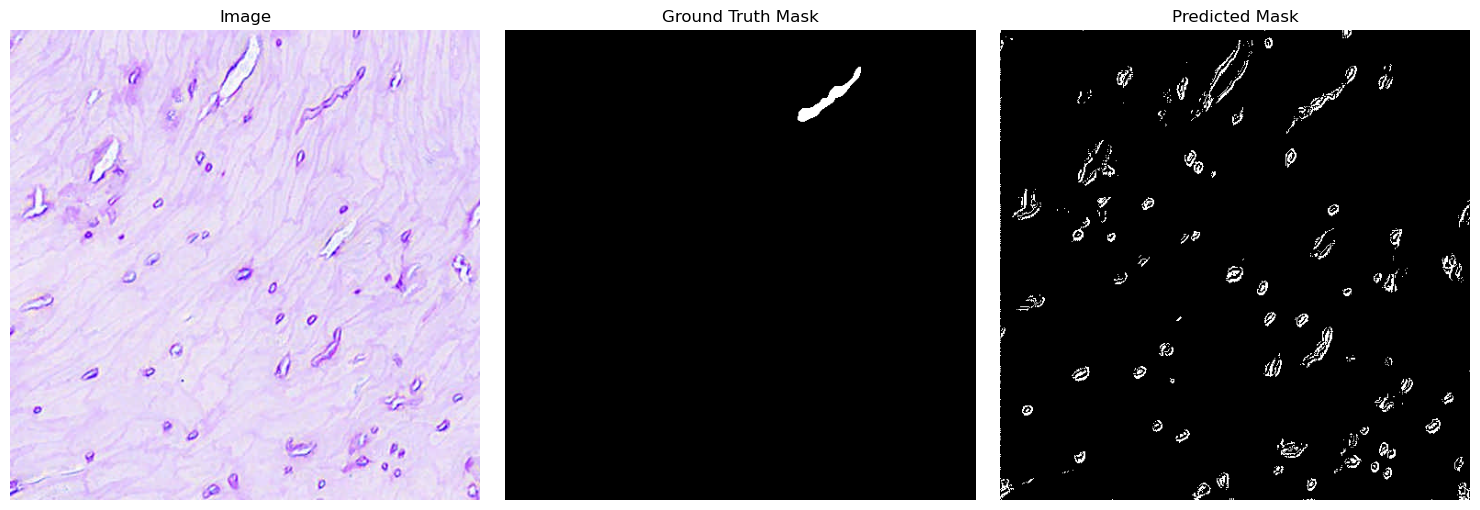

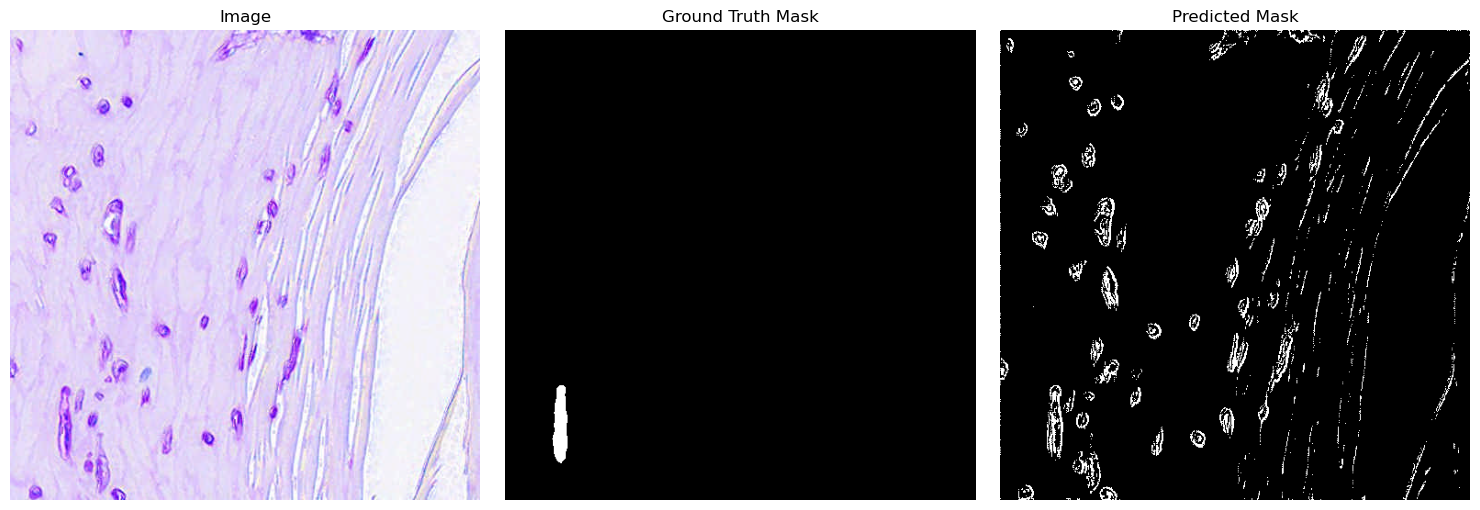

In [33]:
# Put model in evaluation mode
model.eval()

# Get one batch from TRAINING set (if no validation)
imgs, masks = next(iter(train_loader))
imgs = imgs.to(device)
masks = masks.to(device)

# Run inference
with torch.no_grad():
    preds = model(imgs)  # UNet outputs [B,1,H,W] directly
    preds_sigmoid = torch.sigmoid(preds)

# Threshold at 0.5
preds_bin = (preds_sigmoid > 0.5).float() #lowered for testing purposes

# Visualize both samples
for i in range(min(2, imgs.size(0))):
    # Denormalize image
    img_np = imgs[i].cpu().permute(1,2,0).numpy()
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    
    mask_np = masks[i,0].cpu().numpy()
    pred_np = preds_bin[i,0].cpu().numpy()
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_np, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

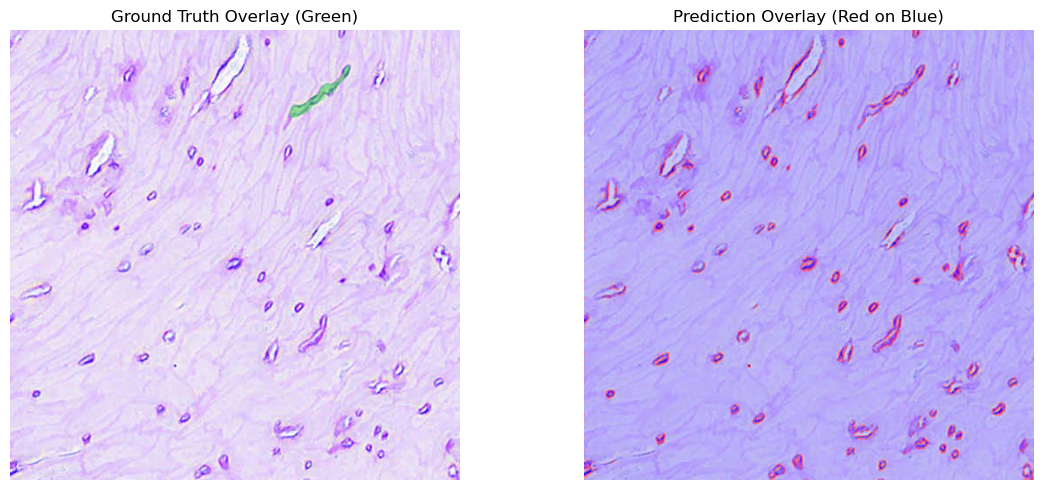

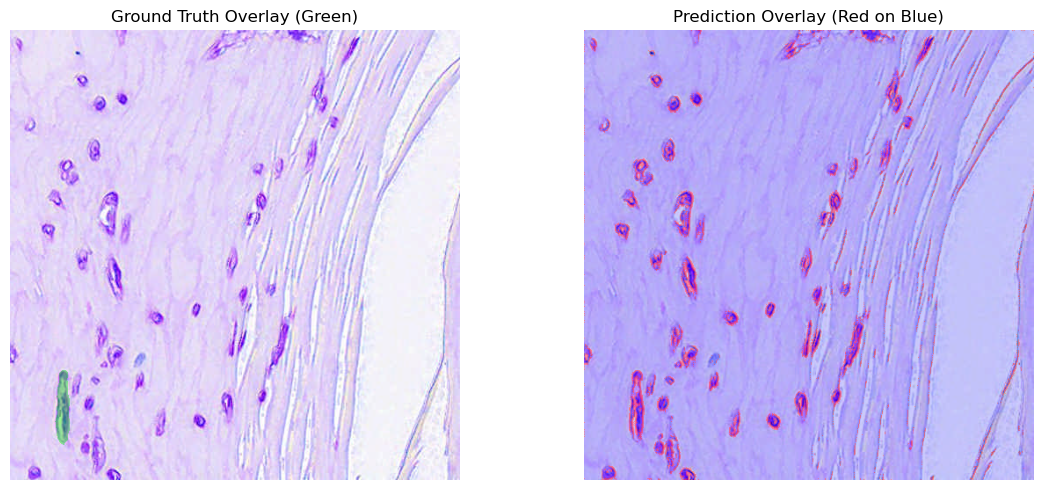

In [34]:
def overlay_mask(image_tensor, mask_tensor, color=[1,0,0], alpha=0.4, bg_tint=None, bg_alpha=0.2):
    """
    Overlay a binary mask on an image.
    
    Args:
        image_tensor: Input image tensor
        mask_tensor: Binary mask tensor
        color: RGB color for the mask overlay
        alpha: Opacity of the mask overlay
        bg_tint: Optional RGB color to tint the background (non-mask areas)
        bg_alpha: Opacity of the background tint
    """
    # Denormalize the image
    img = image_tensor.cpu().permute(1,2,0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    
    # Upsample mask if needed
    if mask_tensor.shape != image_tensor.shape[1:]:
        mask_tensor = F.interpolate(
            mask_tensor.unsqueeze(0).unsqueeze(0),
            size=image_tensor.shape[1:],
            mode='bilinear',
            align_corners=False
        ).squeeze()
    
    mask = mask_tensor.cpu().numpy()
    overlay = img.copy()
    
    for c in range(3):
        if bg_tint is not None:
            # Apply mask color where mask > 0, and background tint where mask == 0
            overlay[:,:,c] = np.where(
                mask > 0, 
                img[:,:,c] * (1 - alpha) + color[c] * alpha,  # Mask areas
                img[:,:,c] * (1 - bg_alpha) + bg_tint[c] * bg_alpha  # Background areas
            )
        else:
            # Original behavior - only overlay the mask
            overlay[:,:,c] = np.where(
                mask > 0, 
                img[:,:,c] * (1 - alpha) + color[c] * alpha, 
                img[:,:,c]
            )
    
    return overlay

# Visualize with overlays
for i in range(min(2, imgs.size(0))):
    img = imgs[i]
    mask_gt = masks[i,0]
    mask_pred = preds_bin[i,0]
    
    overlay_gt = overlay_mask(img, mask_gt, color=[0,1,0], alpha=0.4)    # Green
    overlay_pred = overlay_mask(img, mask_pred, color=[1,0,0], alpha=0.4, 
                                bg_tint=[0,0,1], bg_alpha=0.2)  # Red with blue background
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(overlay_gt)
    plt.title("Ground Truth Overlay (Green)")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(overlay_pred)
    plt.title("Prediction Overlay (Red on Blue)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [28]:
# DIAGNOSTIC: Check what the model is actually outputting
print("="*60)
print("DIAGNOSTIC INFO")
print("="*60)

# Check raw model outputs (before sigmoid)
print(f"\nRaw predictions (logits):")
print(f"  Min: {preds.min().item():.4f}")
print(f"  Max: {preds.max().item():.4f}")
print(f"  Mean: {preds.mean().item():.4f}")
print(f"  Std: {preds.std().item():.4f}")

# Check after sigmoid
print(f"\nAfter sigmoid:")
print(f"  Min: {preds_sigmoid.min().item():.4f}")
print(f"  Max: {preds_sigmoid.max().item():.4f}")
print(f"  Mean: {preds_sigmoid.mean().item():.4f}")

# Check binary predictions
print(f"\nBinary predictions (>0.5):")
print(f"  Pixels predicted as fungus: {preds_bin.sum().item()}")
print(f"  Total pixels: {preds_bin.numel()}")
print(f"  Percentage: {100 * preds_bin.sum().item() / preds_bin.numel():.2f}%")

# Check ground truth for comparison
print(f"\nGround truth:")
print(f"  Pixels labeled as fungus: {masks.sum().item()}")
print(f"  Total pixels: {masks.numel()}")
print(f"  Percentage: {100 * masks.sum().item() / masks.numel():.2f}%")

# Try different thresholds
for threshold in [0.1, 0.3, 0.5, 0.7, 0.9]:
    preds_thresh = (preds_sigmoid > threshold).float()
    print(f"\nThreshold {threshold}: {preds_thresh.sum().item()} pixels")

print("="*60)

DIAGNOSTIC INFO

Raw predictions (logits):
  Min: -3.0720
  Max: 5.5534
  Mean: -2.1935
  Std: 0.2966

After sigmoid:
  Min: 0.0443
  Max: 0.9961
  Mean: 0.1022

Binary predictions (>0.5):
  Pixels predicted as fungus: 1952.0
  Total pixels: 524288
  Percentage: 0.37%

Ground truth:
  Pixels labeled as fungus: 1773.0
  Total pixels: 524288
  Percentage: 0.34%

Threshold 0.1: 189757.0 pixels

Threshold 0.3: 1952.0 pixels

Threshold 0.5: 1701.0 pixels

Threshold 0.7: 1468.0 pixels

Threshold 0.9: 907.0 pixels
